

# **Centralized Training with PyTorch - Adapted for the Bank Account Fraud Use Case and Dataset**  

Author: Anurag Bejju <br>
Team: RBC team 2

## Import Modules

In [1]:
from pathlib import Path

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from torch import nn
from torch.utils.data import DataLoader, Dataset

# Settings for matplotlib
%matplotlib inline
mpl.rc("axes", labelsize=14)
mpl.rc("xtick", labelsize=12)
mpl.rc("ytick", labelsize=12)

# Specify float format for pandas tables
pd.options.display.float_format = "{:.3f}".format

## Load Data

We should first load data and the separate label column from training dataset.

In [42]:
!ls /projects/federated_learning/RBC2/

Bank_Account_Fraud  PaySim1  SynthAML  test.csv


In [2]:
import torch

print("CUDA available:", torch.cuda.is_available())
print("CUDA version (PyTorch compiled with):", torch.version.cuda)
print("CUDA runtime version (from system):", torch.cuda.get_device_properties(0).major, ".", torch.cuda.get_device_properties(0).minor)
print("GPU device name:", torch.cuda.get_device_name(0))


CUDA available: True
CUDA version (PyTorch compiled with): 12.1
CUDA runtime version (from system): 7 . 5
GPU device name: Tesla T4


In [3]:
COL_DF_LABEL_FRAUD = "fraud_bool"
COL_BANK_MONTHS_COUNT = "bank_months_count"
COL_PREV_ADDRESS_MONTHS_COUNT = "prev_address_months_count"
COL_VELOCITY_4W = "velocity_4w"


In [4]:
class FraudDetectionModel(nn.Module):
    def __init__(self, input_dim: int):
        super(FraudDetectionModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.fc2 = nn.Linear(256, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.fc3 = nn.Linear(128, 64)
        self.bn3 = nn.BatchNorm1d(64)
        self.out = nn.Linear(64, 1)

        self.act = nn.GELU()  # Better for deeper networks
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = self.dropout(self.act(self.bn1(self.fc1(x))))
        x = self.dropout(self.act(self.bn2(self.fc2(x))))
        x = self.dropout(self.act(self.bn3(self.fc3(x))))
        x = self.out(x)
        return x


In [5]:
import os
import pandas as pd
import torch
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split

class DataFrameDataset(Dataset):
    def __init__(self, dataframe: pd.DataFrame, label_column: str):
        """
        Args:
            dataframe (pd.DataFrame): Input data in pandas DataFrame format.
            label_column (str): Name of the column to be used as the labels.
        """
        self.features = dataframe.drop(label_column, axis=1).values
        self.labels = dataframe[label_column].values

        # Convert features and labels to torch tensors
        self.features = torch.tensor(self.features, dtype=torch.float32)
        self.labels = torch.tensor(self.labels, dtype=torch.float32)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

class DataModule:
    def __init__(
        self,
        train_df: pd.DataFrame,
        val_df: pd.DataFrame,
        test_df: pd.DataFrame,
        batch_size: int = 32,
        num_workers: int = os.cpu_count(),
        persistent_workers: bool = True,
        prefetch_factor: int = 2,
        label_column: str = 'label'  # Default to 'label', adjust if necessary
    ):
        """
        Args:
            train_df (pd.DataFrame): DataFrame for training data.
            val_df (pd.DataFrame): DataFrame for validation data.
            test_df (pd.DataFrame): DataFrame for testing data.
            batch_size (int): Number of samples per batch.
            num_workers (int): Number of CPU cores used to load data.
            persistent_workers (bool): Whether to keep workers alive for the duration.
            prefetch_factor (int): Number of batches to prefetch.
            label_column (str): Name of the column to use as the label column.
        """
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.persistent_workers = persistent_workers
        self.prefetch_factor = prefetch_factor
        self.label_column = label_column

        # Initialize datasets
        self.train_dataset = DataFrameDataset(self.train_df, label_column=self.label_column)
        self.val_dataset = DataFrameDataset(self.val_df, label_column=self.label_column)
        self.test_dataset = DataFrameDataset(self.test_df, label_column=self.label_column)

    def train_dataloader(self) -> DataLoader:
        """
        Returns the DataLoader for the training dataset.
        """
        return DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            shuffle=True,
            persistent_workers=self.persistent_workers,
            prefetch_factor=self.prefetch_factor,
            pin_memory=True
        )

    def val_dataloader(self) -> DataLoader:
        """
        Returns the DataLoader for the validation dataset.
        """
        return DataLoader(
            self.val_dataset,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            shuffle=False,
            persistent_workers=self.persistent_workers,
            prefetch_factor=self.prefetch_factor,
        )

    def test_dataloader(self) -> DataLoader:
        """
        Returns the DataLoader for the test dataset.
        """
        return DataLoader(
            self.test_dataset,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            shuffle=False,
            persistent_workers=self.persistent_workers,
            prefetch_factor=self.prefetch_factor,
        )

In [6]:
from torchmetrics import (
    Accuracy,
    Recall,
    Precision,
    F1Score,
    AUROC,
    MetricCollection,
)


def get_metrics(num_classes: int):
    accuracy_metrics = get_accuracy_metrics(num_classes=num_classes)
    precision_metrics = get_precision_metrics(num_classes=num_classes)
    f1_score_metrics = get_f1_score_metrics(num_classes=num_classes)
    recall_metrics = get_recall_metrics(num_classes=num_classes)
    auc_metrics = get_auc_metrics(num_classes=num_classes)

    return MetricCollection(
        {
            **accuracy_metrics,
            **recall_metrics,
            **precision_metrics,
            **f1_score_metrics,
            **auc_metrics,
        }
    )


def get_recall_metrics(num_classes: int):
    return {

        "recall_weighted": Recall(
            num_classes=num_classes, average="weighted", task="binary"
        ),
    }


def get_precision_metrics(num_classes: int):
    return {

        "precision_weighted": Precision(
            num_classes=num_classes, average="weighted", task="binary"
        ),
    }


def get_f1_score_metrics(num_classes: int):
    return {

        "f1_score_weighted": F1Score(
            num_classes=num_classes, average="weighted", task="binary"
        ),
    }


def get_accuracy_metrics(num_classes: int):
    return {
        "accuracy_weighted": Accuracy(
            num_classes=num_classes, average="weighted", task="binary")
    }


def get_auc_metrics(num_classes: int):
    return {"auroc": AUROC(num_classes=num_classes, task="binary")}

/ssd003/projects/aieng/public/fl4health_bootcamp/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
import os
import pandas as pd
from typing import Optional, Any

import torch
from torch import nn
from torch.nn.modules.loss import _Loss
from torch.optim import Optimizer, Adam
from torchmetrics import (
    MetricCollection,
    Accuracy,
    Recall,
    Precision,
)


import torch
from torch import nn
from torch.optim import Adam, Optimizer
from torchmetrics import MetricCollection, Accuracy, Recall, Precision
from torch.nn.modules.loss import _Loss
from typing import Optional


class FraudClassifier(nn.Module):  # Inherit from nn.Module
    def __init__(
        self,
        model: nn.Module,
        num_classes: int,
        metrics: Optional[MetricCollection] = None,
        criterion: Optional[_Loss] = None,
        optimizer: Optional[Optimizer] = None,
    ):
        super(FraudClassifier, self).__init__()  # Initialize the parent class

        self.model = model
        self.num_classes = num_classes
        self.metrics = metrics or self.initialize_metrics(num_classes=num_classes)
        self.criterion = criterion or nn.BCEWithLogitsLoss()
        self.optimizer = optimizer or Adam(self.model.parameters())

        # Metrics for train/validation/test
        self.train_metrics = self.metrics.clone(prefix="train_")
        self.val_metrics = self.metrics.clone(prefix="val_")
        self.test_metrics = self.metrics.clone(prefix="test_")

    def initialize_metrics(self, num_classes: int) -> MetricCollection:
        metrics = MetricCollection(
            {
                "accuracy_weighted": Accuracy(average="weighted", task="binary", num_classes=num_classes),
                "recall_weighted": Recall(average="weighted", task="binary", num_classes=num_classes),
                "precision_weighted": Precision(average="weighted", task="binary", num_classes=num_classes),
            }
        )
        return metrics

    def forward(self, inputs: torch.Tensor) -> torch.Tensor:
        return self.model(inputs)

    def step(self, batch: tuple[torch.Tensor, torch.Tensor]):
        inputs, targets = batch
        logits = self.forward(inputs).squeeze()
        targets = targets.long()

        loss = self.criterion(logits, targets.float())
        probs = torch.sigmoid(logits)

        return loss, probs, targets

    def train_step(self, batch: tuple[torch.Tensor, torch.Tensor]):
        loss, probs, targets = self.step(batch=batch)
        self.train_metrics.update(probs, targets)

        return loss

    def validation_step(self, batch: tuple[torch.Tensor, torch.Tensor]):
        loss, probs, targets = self.step(batch=batch)
        self.val_metrics.update(probs, targets)

        return loss

    def test_step(self, batch: tuple[torch.Tensor, torch.Tensor]):
        loss, probs, targets = self.step(batch=batch)
        self.test_metrics.update(probs, targets)

        return {"loss": loss, "probs": probs.detach(), "target": targets}

    def log_metrics(self):
        train_metrics = self.train_metrics.compute()
        val_metrics = self.val_metrics.compute()
        test_metrics = self.test_metrics.compute()

        print(f"Train Metrics: {train_metrics}")
        print(f"Validation Metrics: {val_metrics}")
        print(f"Test Metrics: {test_metrics}")

        self.train_metrics.reset()
        self.val_metrics.reset()
        self.test_metrics.reset()

    def configure_optimizers(self) -> Optimizer:
        return self.optimizer

    def train_epoch(self, train_loader: torch.utils.data.DataLoader):
        self.model.train()
        total_loss = 0.0

        for batch in train_loader:
            loss = self.train_step(batch)
            total_loss += loss.item()

        self.log_metrics()
        return total_loss / len(train_loader)

    def validate_epoch(self, val_loader: torch.utils.data.DataLoader):
        self.model.eval()
        total_loss = 0.0

        with torch.no_grad():
            for batch in val_loader:
                loss = self.validation_step(batch)
                total_loss += loss.item()

        self.log_metrics()
        return total_loss / len(val_loader)

    def test_epoch(self, test_loader: torch.utils.data.DataLoader):
        self.model.eval()
        total_loss = 0.0

        with torch.no_grad():
            for batch in test_loader:
                loss_info = self.test_step(batch)
                total_loss += loss_info['loss'].item()

        self.log_metrics()
        return total_loss / len(test_loader)


In [8]:
import os
from typing import List, Tuple

class TrainerManager:
    def __init__(
        self,
        pl_model: nn.Module,  # Generalized to work with any PyTorch model
        pl_datamodule: Dataset,  # Dataset should be used instead of DataModule
        run_datadir: str = f"./model_trainer",
    ):
        self.pl_model = pl_model
        self.pl_datamodule = pl_datamodule
        self.run_datadir = Path(run_datadir)

        # Logger for MLFlow (optional, for tracking)
        self._logger = None
        self._callback_list = []
        self.optimizer = Adam(self.pl_model.parameters(), lr=1e-3)  # Optimizer for model
        self.trainer = None

    def set_seed(self, seed: int = 42):
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

    def save_checkpoint(self, epoch, loss, accuracy, checkpoint_dir="checkpoints"):
        """
        Save the model and optimizer state_dict along with epoch, loss, and accuracy.
        """
        os.makedirs(checkpoint_dir, exist_ok=True)
        checkpoint_path = os.path.join(checkpoint_dir, f"checkpoint_epoch_{epoch+1}.pth")
        torch.save({
            'epoch': epoch,
            'model_state_dict': self.pl_model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'loss': loss,
            'accuracy': accuracy,
        }, checkpoint_path)
        print(f"Checkpoint saved at {checkpoint_path}")
    
    def train(
        self, epochs: int = 10, use_gpu: bool = False
    ) -> Tuple[nn.Module, dict]:

        self.set_seed()

        device = "cuda" if use_gpu and torch.cuda.is_available() else "cpu"
        self.pl_model.to(device)
        
        # Loss function
        criterion = nn.BCEWithLogitsLoss()

        # Training loop
        for epoch in range(epochs):
            self.pl_model.train()  # Set model to training mode
            running_loss = 0.0
            correct = 0
            total = 0
            train_loader = self.pl_datamodule.train_dataloader()

            for inputs, targets in train_loader:  # Assuming DataLoader is used for pl_datamodule
                inputs, targets = inputs.to(device), targets.to(device)

                # Zero the parameter gradients
                self.optimizer.zero_grad()

                # Forward pass
                outputs = self.pl_model(inputs).squeeze()
                loss = criterion(outputs, targets.float())

                # Backward pass
                loss.backward()

                # Optimize
                self.optimizer.step()

                running_loss += loss.item()

                # Calculate accuracy metrics
                preds = torch.sigmoid(outputs)
                correct += (preds.round() == targets).sum().item()
                total += targets.size(0)

            epoch_loss = running_loss / len(train_loader)
            epoch_accuracy = correct / total

            print(f"Epoch {epoch+1}/{epochs} - Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}")

            # Save a checkpoint every 5 epochs (you can change this condition as needed)
            if (epoch + 1) % 5 == 0:
                self.save_checkpoint(epoch, epoch_loss, epoch_accuracy, self.run_datadir)

        return self.pl_model, {"loss": epoch_loss, "accuracy": epoch_accuracy}

    def load_best_model(self, checkpoint_path: str) -> nn.Module:
        """
        Load the best model from the checkpoint.
        """
        if not Path(checkpoint_path).exists():
            raise ValueError(f"Checkpoint not found at {checkpoint_path}")
        
        checkpoint = torch.load(checkpoint_path)
        self.pl_model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        return self.pl_model

    def test(self) -> dict:
        """
        Run the model on the test set.
        """
        self.pl_model.eval()  # Set model to evaluation mode
        running_loss = 0.0
        correct = 0
        total = 0

        # Assuming DataLoader is used for pl_datamodule
        with torch.no_grad():
            test_loader = self.pl_datamodule.test_dataloader()
            for inputs, targets in test_loader:
                inputs, targets = inputs.to(device), targets.to(device)

                outputs = self.pl_model(inputs).squeeze()
                loss = nn.BCEWithLogitsLoss()(outputs, targets.float())
                running_loss += loss.item()

                preds = torch.sigmoid(outputs)
                correct += (preds.round() == targets).sum().item()
                total += targets.size(0)

        epoch_loss = running_loss / len(test_loader)
        epoch_accuracy = correct / total

        print(f"Test - Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}")
        
        return {"loss": epoch_loss, "accuracy": epoch_accuracy}


In [9]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder


def preprocess_with_labelencoder(df: pd.DataFrame, col_label: str):
    # Identify categorical and numerical features
    categorical_features = df.select_dtypes(include=["object", "category"]).columns
    numerical_features = df.select_dtypes(include=["number"]).columns

    categorical_features = [
        features for features in categorical_features if features != col_label
    ]
    numerical_features = [
        features for features in numerical_features if features != col_label
    ]

    # Initialize dictionaries to store the encoders and scaler
    label_encoders = {}
    scaler = StandardScaler()

    # Encode categorical features using LabelEncoder
    for col in categorical_features:
        label_encoders[col] = LabelEncoder()
        df[col] = label_encoders[col].fit_transform(df[col])

    # Scale numerical features
    df[numerical_features] = scaler.fit_transform(df[numerical_features])

    return df, label_encoders, scaler

In [10]:
import numpy as np

df_nn = pd.read_csv("/projects/federated_learning/RBC2/Bank_Account_Fraud/Base.csv")

COL_DF_LABEL_FRAUD = "fraud_bool"
COL_BANK_MONTHS_COUNT = "bank_months_count"
COL_PREV_ADDRESS_MONTHS_COUNT = "prev_address_months_count"
COL_VELOCITY_4W = "velocity_4w"

cols_missing = [
    'current_address_months_count',
    'session_length_in_minutes',
    'device_distinct_emails_8w',
    'intended_balcon_amount'
]

df_nn = df_nn.drop(columns=[
    COL_BANK_MONTHS_COUNT, 
    COL_PREV_ADDRESS_MONTHS_COUNT,
    COL_VELOCITY_4W
    ]
)

cols_missing = [
    'current_address_months_count',
    'session_length_in_minutes',
    'device_distinct_emails_8w',
    'intended_balcon_amount'
]

df_nn[cols_missing] = df_nn[cols_missing].replace(-1, np.nan)
df_nn= df_nn.dropna()

df_preprocessed_nn, label_encoder, sclarer = preprocess_with_labelencoder(
    df=df_nn, 
    col_label=COL_DF_LABEL_FRAUD
)

In [11]:
from sklearn.model_selection import train_test_split

test_size = 0.30
val_size = 0.5

# First, do stratified splits to preserve class distribution
train_df, test_df = train_test_split(
    df_preprocessed_nn,
    test_size=test_size,
    random_state=42,
    shuffle=True,
    stratify=df_preprocessed_nn[COL_DF_LABEL_FRAUD],
)

test_df, val_df = train_test_split(
    test_df,
    test_size=val_size,
    shuffle=True,
    random_state=42,
    stratify=test_df[COL_DF_LABEL_FRAUD],
)

# Separate features and labels for SMOTE
majority_class = train_df[train_df[COL_DF_LABEL_FRAUD] == 0]
minority_class = train_df[train_df[COL_DF_LABEL_FRAUD] == 1]

# Oversample the minority class by duplicating rows
minority_oversampled = minority_class.sample(
    n=len(majority_class), replace=True, random_state=42
)

# Combine and shuffle
train_df_balanced = pd.concat([majority_class, minority_oversampled])
train_df_balanced = train_df_balanced.sample(frac=1.0, random_state=42).reset_index(drop=True)

In [12]:
from sklearn.utils.class_weight import compute_class_weight
# Compute the class weights
class_weights = compute_class_weight(
        class_weight="balanced",
        classes=train_df_balanced[COL_DF_LABEL_FRAUD].unique(),
        y=train_df_balanced[COL_DF_LABEL_FRAUD],
    )
tensor_class_weights = torch.tensor(data=class_weights, dtype=torch.float32)

In [13]:
pl_datamodule = DataModule(
    train_df=train_df_balanced,
    val_df=val_df,
    test_df=test_df, 
    batch_size=128,
    prefetch_factor=2,
    persistent_workers=True,
    label_column = COL_DF_LABEL_FRAUD,
    num_workers = 1
)

num_classes = tensor_class_weights.shape[0]
print(tensor_class_weights)

tensor([1., 1.])


In [14]:
from torch.nn import BCEWithLogitsLoss

fraud_ratio = train_df[COL_DF_LABEL_FRAUD].mean()
nonfraud_ratio = 1 - fraud_ratio

# inverse of frequency as weight (for BCEWithLogitsLoss)
pos_weight = torch.tensor(nonfraud_ratio / fraud_ratio)
pos_weight


tensor(89.3747, dtype=torch.float64)

In [15]:
from torch.nn import BCEWithLogitsLoss

fraud_ratio = train_df[COL_DF_LABEL_FRAUD].mean()
nonfraud_ratio = 1 - fraud_ratio

# inverse of frequency as weight (for BCEWithLogitsLoss)
pos_weight = torch.tensor(nonfraud_ratio / fraud_ratio)



model = FraudDetectionModel(df_nn.shape[1]-1)
metrics= get_metrics(num_classes=num_classes)
criterion = BCEWithLogitsLoss(pos_weight=pos_weight)


In [16]:
pl_model = FraudClassifier(
    num_classes=num_classes,
    model=model,
    metrics=metrics,
    criterion=criterion,
)

In [20]:
run_datadir = "output3/"

trainer = TrainerManager(
    pl_datamodule=pl_datamodule,
    pl_model=pl_model,
    run_datadir=run_datadir
)



In [86]:
model_trained, _ = trainer.train(epochs=50, use_gpu=True)

Epoch 1/50 - Loss: 0.4211, Accuracy: 0.8082
Epoch 2/50 - Loss: 0.3700, Accuracy: 0.8345
Epoch 3/50 - Loss: 0.3428, Accuracy: 0.8499
Epoch 4/50 - Loss: 0.3275, Accuracy: 0.8586
Epoch 5/50 - Loss: 0.3177, Accuracy: 0.8646
Checkpoint saved at output3/checkpoint_epoch_5.pth
Epoch 6/50 - Loss: 0.3089, Accuracy: 0.8691
Epoch 7/50 - Loss: 0.3034, Accuracy: 0.8725
Epoch 8/50 - Loss: 0.2991, Accuracy: 0.8748
Epoch 9/50 - Loss: 0.2954, Accuracy: 0.8768
Epoch 10/50 - Loss: 0.2923, Accuracy: 0.8787
Checkpoint saved at output3/checkpoint_epoch_10.pth
Epoch 11/50 - Loss: 0.2894, Accuracy: 0.8801
Epoch 12/50 - Loss: 0.2875, Accuracy: 0.8814
Epoch 13/50 - Loss: 0.2845, Accuracy: 0.8828
Epoch 14/50 - Loss: 0.2832, Accuracy: 0.8836
Epoch 15/50 - Loss: 0.2816, Accuracy: 0.8845
Checkpoint saved at output3/checkpoint_epoch_15.pth
Epoch 16/50 - Loss: 0.2800, Accuracy: 0.8850
Epoch 17/50 - Loss: 0.2791, Accuracy: 0.8858
Epoch 18/50 - Loss: 0.2772, Accuracy: 0.8865
Epoch 19/50 - Loss: 0.2763, Accuracy: 0.8873

In [19]:
targets

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 0.], device='cuda:0')

In [17]:
print(next(model_trained.parameters()).device)  # Check model device
print(inputs.device)

NameError: name 'model_trained' is not defined

In [43]:
import torch

# 1. Create the model architecture
model_trained = FraudClassifier(
    num_classes=num_classes,
    model=model,
    metrics=metrics,
    criterion=criterion,
)

# 2. Load the checkpoint
checkpoint_path = "output3/checkpoint_epoch_50.pth"  # or .pth
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the checkpoint
checkpoint = torch.load(checkpoint_path, map_location=device)

# Load only model weights
model_trained.load_state_dict(checkpoint["model_state_dict"])

# Move the model to the correct device (GPU or CPU)
model_trained.to(device)

# Ensure the model is in evaluation mode
model_trained.eval()

# Now using the dataloader to loop through test data
test_dataloader = pl_datamodule.test_dataloader()

y_true_nn = []
y_probs_nn = []
all_preds = []

# Iterate through the test data
for batch in test_dataloader:
    # Move the inputs and targets to the same device as the model
    inputs, targets = batch
    inputs, targets = inputs.to(device), targets.to(device)

    # Forward pass through the model
    with torch.no_grad():  # Disable gradient computation during evaluation
        outputs = model_trained(inputs)

    # Process outputs and get probabilities
    probabilities = torch.sigmoid(outputs).squeeze()

    # Store predictions
    preds = (probabilities > 0.5).long()  # Threshold to classify
    y_true_nn.extend(targets.cpu().numpy())  # Store true labels on CPU
    y_probs_nn.extend(probabilities.cpu().numpy())  # Store probabilities on CPU
    all_preds.extend(preds.cpu().numpy())  # Store predictions on CPU


/tmp/ipykernel_7059/3043917138.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)


In [44]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, roc_curve, auc

class PerformancePlotter:
    def __init__(self):
        pass

    def plot_auc_curve(self, y_true, y_probs, ax=None):
        fpr, tpr, _ = roc_curve(y_true, y_probs)
        roc_auc = auc(fpr, tpr)
        should_display = False
        if ax is None:
            fig, ax = plt.subplots(figsize=(8, 6))
            should_display = True
        ax.plot(
            fpr,
            tpr,
            color="darkorange",
            lw=2,
            label=f"ROC curve (area = {roc_auc:.2f})",
        )
        ax.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel("False Positive Rate")
        ax.set_ylabel("True Positive Rate")
        ax.set_title("Receiver Operating Characteristic")
        ax.legend(loc="lower right")
        if should_display:
            plt.show()

    def plot_precision_recall_curve(self, y_true, y_probs, ax=None):
        precisions, recalls, thresholds = precision_recall_curve(y_true, y_probs)
        should_display = False
        if ax is None:
            fig, ax = plt.subplots(figsize=(8, 6))
            should_display = True
        ax.plot(recalls, precisions, label="Precision-Recall Curve")
        ax.set_xlabel("Recall")
        ax.set_ylabel("Precision")
        ax.legend(loc="best")
        ax.set_title("Precision-Recall Curve")
        if should_display:
            plt.show()

    def plot_precision_recall_f1_vs_threshold(self, y_true, y_probs, ax=None):
        precisions, recalls, thresholds = precision_recall_curve(y_true, y_probs)
        f1_scores = 2 * (precisions * recalls) / (precisions + recalls)
        should_display = False
        if ax is None:
            fig, ax = plt.subplots(figsize=(8, 6))
            should_display = True
        ax.plot(thresholds, f1_scores[:-1], "r-", label="F1-score")
        ax.plot(thresholds, precisions[:-1], "b--", label="Precision")
        ax.plot(thresholds, recalls[:-1], "g-", label="Recall")
        ax.set_xlabel("Threshold")
        ax.set_ylabel("Precision/Recall")
        ax.legend(loc="best")
        ax.set_title("Precision and Recall vs. Threshold")
        ax.grid(True)
        if should_display:
            plt.show()

    def plot_metrics(self, y_true, y_probs):
        fig, axs = plt.subplots(1, 3, figsize=(18, 6))
        self.plot_auc_curve(y_true, y_probs, ax=axs[0])
        self.plot_precision_recall_curve(y_true, y_probs, ax=axs[1])
        self.plot_precision_recall_f1_vs_threshold(y_true, y_probs, ax=axs[2])
        plt.tight_layout()
        plt.show()

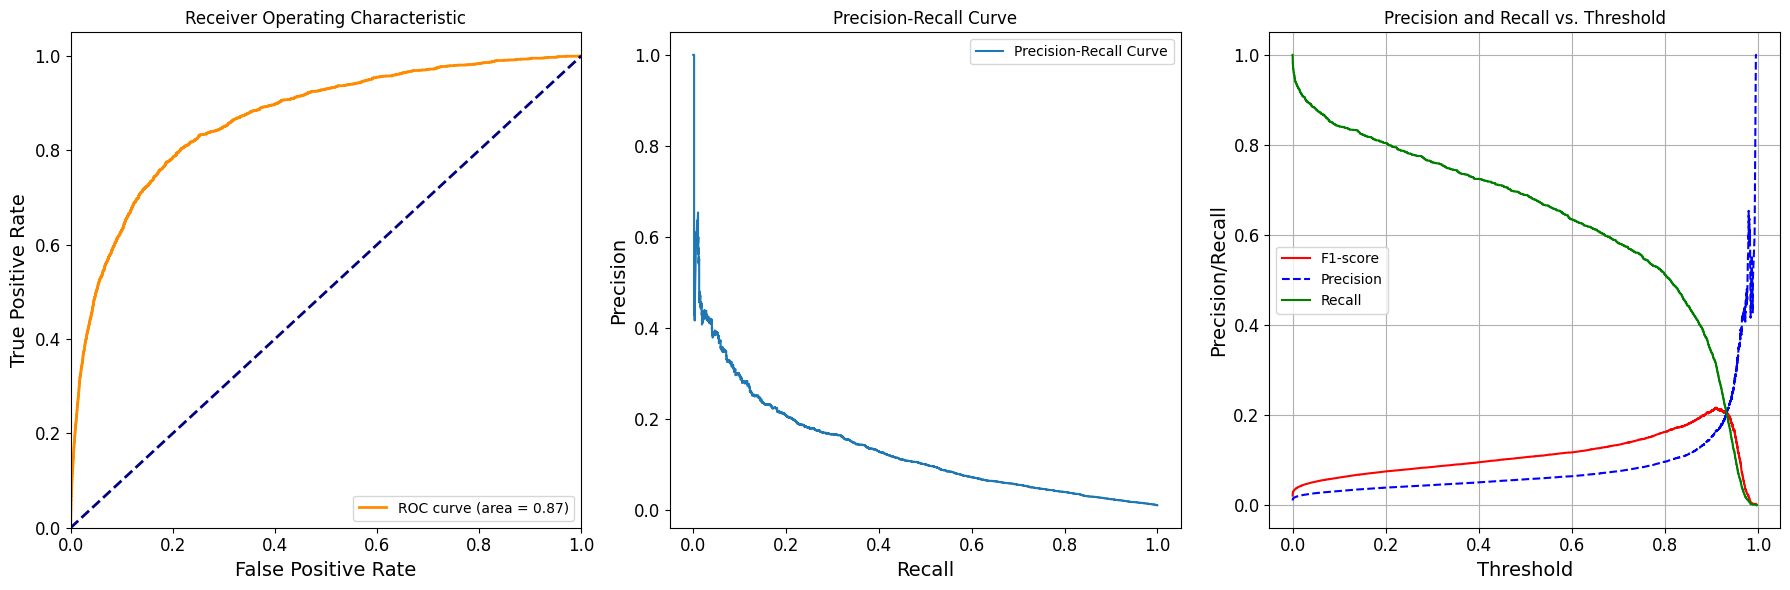

In [45]:
plotter = PerformancePlotter()
plotter.plot_metrics(y_true_nn, y_probs_nn) 

/tmp/ipykernel_7059/1040626301.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(file, map_location='cpu')  # Load the checkpoint (use 'cuda' if n

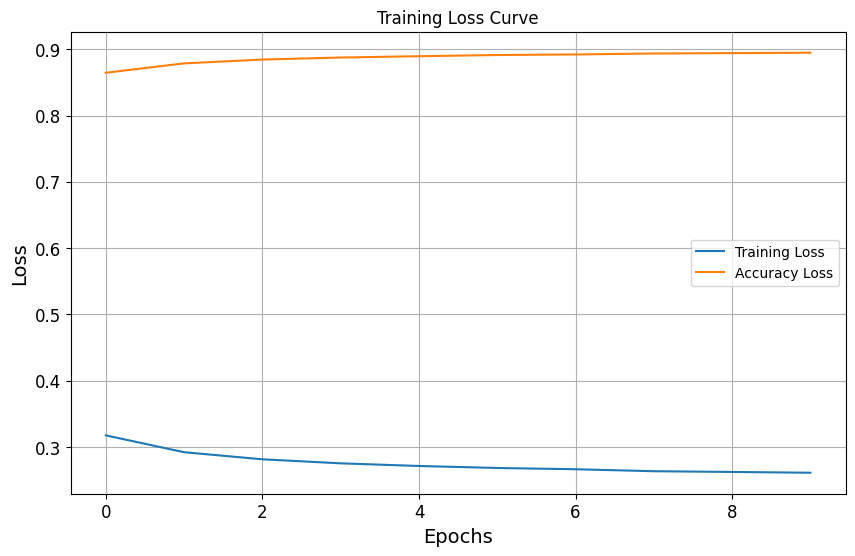

In [70]:

import glob
import torch
import matplotlib.pyplot as plt
loss_history = []  # Adjust the key based on your checkpoint format
accuracy_history = []
# Load the checkpoint

path_df = pd.DataFrame(glob.glob("output3/*"), columns=['path_name'])
path_df['id_val'] = path_df.path_name.apply(lambda x: x.split('_')[-1].split('.')[0]).astype(int)
path_df = path_df.sort_values('id_val')



for file in path_df.path_name.values:
    #checkpoint_path = "output3/checkpoint_epoch_50.pth"  # Path to your checkpoint
    checkpoint = torch.load(file, map_location='cpu')  # Load the checkpoint (use 'cuda' if needed)
    loss_history.append(checkpoint.get('loss', None))
    accuracy_history.append(checkpoint.get('accuracy', None))


# If loss_history is available, plot the loss curve
if loss_history is not None:
    # Plotting the training loss curve
    plt.figure(figsize=(10, 6))
    plt.plot(loss_history, label="Training Loss")
    plt.plot(accuracy_history, label="Accuracy Loss")
    plt.title("Training Loss Curve")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("No loss history found in checkpoint.")

In [46]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

Confusion Matrix:
 [[128965  18427]
 [   513   1136]]


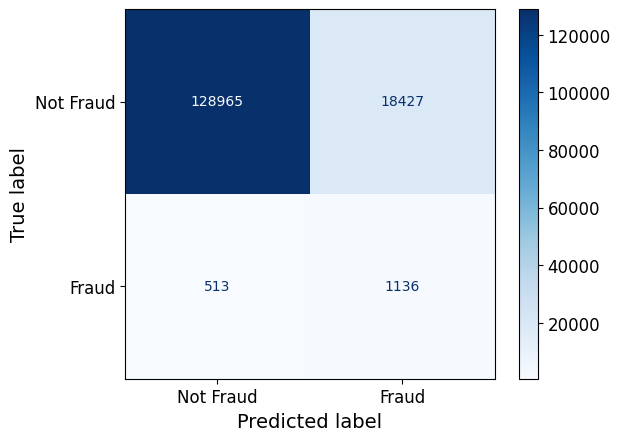

In [47]:
cm = confusion_matrix(y_true_nn, all_preds)
print("Confusion Matrix:\n", cm)

# Optional: make it pretty
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Fraud", "Fraud"])
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [48]:
from sklearn.metrics import classification_report
import numpy as np

# Generate classification report
report = classification_report(y_true_nn, all_preds)
print(report)

              precision    recall  f1-score   support

         0.0       1.00      0.87      0.93    147392
         1.0       0.06      0.69      0.11      1649

    accuracy                           0.87    149041
   macro avg       0.53      0.78      0.52    149041
weighted avg       0.99      0.87      0.92    149041

